In [1]:
import os 
import pandas as pd 
import numpy as np 
import wandb

import matplotlib.pyplot as plt 
%matplotlib inline 

import torch 
from torch import nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from PIL import Image
import math

pd.set_option('display.max_colwidth', None)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Hyperparameters
EMBEDDING_DIM = 104
HIDDEN_DIM = 512
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 4
NUM_EPOCHS = 50
NUM_HEADS = 8
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
CAPTIONS_LENGTH = 25
MAX_PLATEAU_COUNT = 15
NUM_CYCLES = 3
# Some paths and files

IMAGE_PATH = 'data/flickr8k/Images/'
CAPTIONS_FILE = 'data/flickr8k/captions.txt'
EMBEDDING_FILE = 'embedding/glove-wiki-gigaword-100.txt'
CHECKPOINT_PATH = 'data/checkpoints/checkpoint.pth'
CAPTIONS_PATH = 'split_data/'

cuda


In [3]:
vocab, embeddings = [], []
with open(EMBEDDING_FILE, 'rt', encoding='utf-8') as fr:
    full_content = fr.read().strip().split('\n')

for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    i_embeddings.extend([0.0, 0.0, 0.0, 0.0])
    vocab.append(i_word)
    embeddings.append(i_embeddings)

vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

unk_embedding = np.mean(embs_npa, axis=0).tolist()

dim = embs_npa.shape[1]
sos_embedding = [0.0] * dim
sos_embedding[-3] = 1.0
eos_embedding = [0.0] * dim
eos_embedding[-2] = 1.0
pad_embedding = [0.0] * dim
pad_embedding[-4] = 1.0
# unk_embedding = [0.0] * dim
# unk_embedding[-1] = 1.0

# Update vocab and embeddings
vocab = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"] + vocab
embeddings = [pad_embedding, sos_embedding, eos_embedding, unk_embedding] + embeddings

vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)



In [ ]:
stoi_dict = {word: idx for idx, word in enumerate(vocab_npa)}
_unk_idx = stoi_dict["<UNK>"]

def stoi(string):
    return stoi_dict.get(string, _unk_idx)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [6]:
pad_idx = stoi("<PAD>")

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, maxlen=50):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* (np.log(10000) / emb_size))
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        self.pos_embedding = pos_embedding.unsqueeze(-2).to(device)

    def forward(self, x):
        x = x + self.pos_embedding[:x.size(0), :]
        return x

In [7]:
class ImageCaptioningTransformer(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_heads, num_encoder_layers, num_decoder_layers, pad_idx):
        super(ImageCaptioningTransformer, self).__init__()
        self.pad_idx = pad_idx

        # CNN Encoder
        resnet = models.resnet50(weights='IMAGENET1K_V2')
        for param in resnet.parameters():
            param.requires_grad = False
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])  # Remove the last two layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.cnn_linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_size, nhead=num_heads
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_encoder_layers
        )

        # Embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float(), freeze=True)

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(emb_size=embed_size)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size, nhead=num_heads
        )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=num_decoder_layers
        )

        # Output Layer
        self.fc_out = nn.Linear(embed_size, vocab_size)

    def make_src_mask(self, src):
        # src: [batch_size, src_len]
        src_mask = (src != self.pad_idx).unsqueeze(-2)
        return src_mask

    def forward(self, images, captions):
        # Encode images
        features = self.cnn(images)  # [batch_size, C, H, W]
        features = self.avgpool(features).squeeze(-1).squeeze(-1)  # [batch_size, C]
        features = self.cnn_linear(features)  # [batch_size, embed_size]
        features = self.bn(features)  # [batch_size, embed_size]
        features = features.unsqueeze(1)  # [batch_size, 1, embed_size]
    
        # Transformer Encoder
        encoder_outputs = self.transformer_encoder(features.permute(1, 0, 2))  # [1, batch_size, embed_size]
    
        # Prepare captions
        embeddings = self.embedding(captions)  # [batch_size, seq_len, embed_size]
        embeddings = embeddings.permute(1, 0, 2)  # [seq_len, batch_size, embed_size]
        embeddings = self.positional_encoding(embeddings)
    
        # Create masks
        # tgt_mask = nn.Transformer.generate_square_subsequent_mask(CAPTIONS_LENGTH).to(embeddings.device)
        tgt_mask = torch.triu(torch.ones((CAPTIONS_LENGTH, CAPTIONS_LENGTH), device=captions.device), diagonal=1).bool()

        tgt_key_padding_mask = (captions == self.pad_idx)  # Corrected line
        
        # Transformer Decoder
        outputs = self.transformer_decoder(
            embeddings,
            encoder_outputs,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )  # [seq_len, batch_size, embed_size]

        # Extract the last time step's output
        outputs = outputs[-1, :, :]  # [batch_size, embed_size]
    
        outputs = self.fc_out(outputs)  # [batch_size, vocab_size]

        return outputs # [batch_size, vocab_size]


In [8]:
'''Testing model'''
import torch


trained_model = ImageCaptioningTransformer(
    embed_size=EMBEDDING_DIM,
    vocab_size=len(vocab_npa),
    hidden_size=HIDDEN_DIM,
    num_heads=NUM_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    pad_idx=pad_idx
).to(device)
state_dict = torch.load('data/checkpoints/checkpoint.pth', weights_only=True)['model_state_dict']
trained_model.load_state_dict(state_dict)
trained_model.eval()
pass

/home/thanh309/miniconda3/envs/thanh309-ml/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<SOS> two people are playing on the beach . <EOS> 
<SOS> two children are playing on the beach . <EOS> 
<SOS> two children are playing on the beach . <EOS> 
<SOS> two children are playing with a man on the beach . <EOS> 
<SOS> two people are playing on the beach . <EOS> 


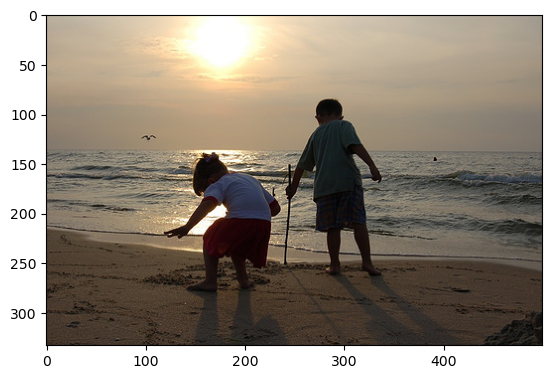

In [16]:
img_path = 'data/flickr8k/Images/1322323208_c7ecb742c6.jpg'
# img_path = 'test.jpg'
img = transform(Image.open(img_path).convert("RGB"))
img = torch.unsqueeze(img, 0).to(device)


pad_idx = stoi('<PAD>')
sos_idx = stoi('<SOS>')
eos_idx = stoi('<EOS>')
unk_idx = stoi('<UNK>')

num_captions = 5
temperature = 0.2

for _ in range(num_captions):

    caption = [[pad_idx for _ in range(CAPTIONS_LENGTH)]]
    caption = torch.tensor(caption).to(device)
    caption[0, 0] = sos_idx
    caption_str = '<SOS> '

    next_idx = 1
    with torch.no_grad():
        while next_idx < CAPTIONS_LENGTH:
            output_logits = trained_model(img, caption)
            output_logits = output_logits / temperature

            output_probs = torch.softmax(output_logits, dim=-1)
            output = torch.multinomial(output_probs, num_samples=1).item()

            if output == unk_idx:
                continue

            caption_str += f'{vocab_npa[output]} '
            caption[0, next_idx] = output

            if output == eos_idx:
                break

            next_idx += 1
    print(caption_str)


plt.imshow(Image.open(img_path).convert("RGB"))
pass